In [2]:
import torch
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import imp
import core
import resnet
import utils
%matplotlib inline

In [3]:
wd = 'E:/new_data/kaggle/planet/'
train_set = pd.read_csv(wd + 'train_v2.csv')
train_set['tags'] = train_set['tags'].apply(lambda x: x.split(' '))
test_set = pd.read_csv(wd+'sample_submission_v2.csv')
train_tags = ['clear', 'partly_cloudy', 'haze', 'cloudy', 'primary', 'agriculture', 'road', 'water',
             'cultivation', 'habitation', 'bare_ground', 'selective_logging', 'artisinal_mine', 
              'blooming', 'slash_burn', 'conventional_mine', 'blow_down']
label_map = {l: i for i, l in enumerate(train_tags)}
inv_label_map = {i: l for l, i in label_map.items()}

In [146]:
# 载入数据
from sklearn.model_selection import train_test_split
from time import time
file_all = train_set['image_name'].values
y_all = utils.get_y(train_set['tags'].values, label_map)
x_tr, x_vl, y_tr, y_vl = train_test_split(file_all, y_all, test_size=0.8, random_state=int(time()))

In [147]:
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms
import random
from PIL import Image
from time import time
import mydataset
imp.reload(utils)
imp.reload(core)
imp.reload(mydataset)
imp.reload(resnet)
import gc
for i in range(10):
    gc.collect()

# 超参数
batch_size = 256
pic_size = (64, 64)
learning_rate = 1e-3
num_epoches = 1000
tolerance = 15
lr_tolerance = 15
best_model = core.BestModel()
transform1 = transforms.Compose([
#     transforms.RandomCrop(pic_size),
    transforms.RandomHorizontalFlip(),
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def transform_tr(img, pic_size):
    img = img.resize(pic_size)
    img = img.transpose(Image.FLIP_LEFT_RIGHT)  if random.randint(0, 1) > .5 else img
    img = img.transpose(Image.FLIP_TOP_BOTTOM)  if random.randint(0, 1) > .5 else img
    img.rotate(np.random.random() * 45)
    img_tensor = transform2(img)
    return img_tensor

def transform_vl(img, pic_size):
    img = img.resize(pic_size)
    img_tensor = transform2(img)
    return img_tensor

probs = [0.5, 0.6, 0.8, 0.8, 0.5, 0.5, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [148]:
model = core.MyNet(17).cuda()
#model = resnet.ResNet(pic_width=pic_size[0], num_classes=17, block=resnet.BasicBlock).cuda()
criterion = nn.BCELoss(weight=None).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = core.History(['train loss', 'valid loss'])

estimator = core.Estimator(model, criterion, optimizer)
for epoch in range(num_epoches):
    time_st = time()
    train_loader = utils.weighted_train_loader(x_tr, y_tr, probs, transform_tr, batch_size, pic_size)
    loss_tr = estimator.train(train_loader)
    
    val_loader = utils.valid_loader(x_vl, y_vl, transform_vl, batch_size, pic_size)
    loss_vl, f2_vl = estimator.validate(val_loader)
    best_model.update(loss_vl.avg, f2_vl, estimator.model)
    
    if epoch > lr_tolerance and best_model.lrcount > lr_tolerance:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
        print('New Learn Rate: {}!'.format(new_lr))
        best_model.lrcount = 0
        
    if epoch > tolerance and best_model.nobetter > tolerance:
        print('Early Stop in Epoch: {}, Best Val-Loss: {:.6f}, Best F2: {:.6f}'.format(
            epoch+1, best_model.best_loss, best_model.best_f2.value(bestf2=True)))
        break
        
    print('[{}/{}] {}s, Loss: {:.4f}, Val-Loss: {:.4f}, Best Val-Loss: {:.4f}, Val-F2: {:.3f}'.format(
        epoch+1, num_epoches, int(time() - time_st), loss_tr.avg, loss_vl.avg,
        best_model.best_loss, f2_vl.value(0.3)))
    history.update({'train loss': loss_tr.avg, 'valid loss': loss_vl.avg})
    gc.collect()
history.plot(['train loss', 'valid loss'])

Update Model!
[1/1000] 92s, Loss: 0.6165, Val-Loss: 0.5070, Best Val-Loss: 0.5070, Val-F2: 0.451
Update Model!
[2/1000] 93s, Loss: 0.3582, Val-Loss: 0.2051, Best Val-Loss: 0.2051, Val-F2: 0.813
Update Model!
[3/1000] 95s, Loss: 0.2059, Val-Loss: 0.1651, Best Val-Loss: 0.1651, Val-F2: 0.839
Update Model!
[4/1000] 94s, Loss: 0.1838, Val-Loss: 0.1566, Best Val-Loss: 0.1566, Val-F2: 0.843


KeyboardInterrupt: 

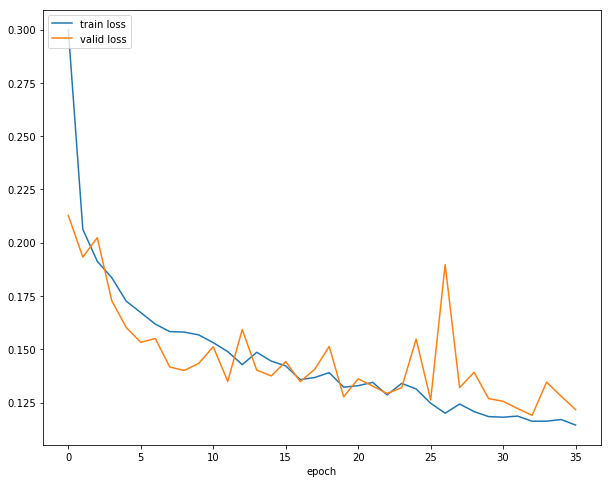

In [141]:
history.plot(['train loss', 'valid loss'])

In [182]:
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms
import random
import model as m
from PIL import Image
from time import time
import mydataset
import gc
imp.reload(mydataset)
imp.reload(core)
imp.reload(utils)
imp.reload(m)
for i in range(10):
    gc.collect()

# 超参数
batch_size = 256
pic_size = (64, 64)
learning_rate = 1e-3
num_epoches = 1000
tolerance = 15
lr_tolerance = 7
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def transform_tr(img, pic_size):
    img = img.resize(pic_size)
    img = img.transpose(Image.FLIP_LEFT_RIGHT)  if random.randint(0, 1) > .5 else img
    img = img.transpose(Image.FLIP_TOP_BOTTOM)  if random.randint(0, 1) > .5 else img
    img.rotate(np.random.random() * 45)
    img_tensor = transform2(img)
    return img_tensor

def transform_vl(img, pic_size):
    img = img.resize(pic_size)
    img_tensor = transform2(img)
    return img_tensor

In [162]:
a = torch.Tensor([3,0, 5.9])
a = torch.autograd.Variable(a)
a.long()

Variable containing:
 3
 0
 5
[torch.LongTensor of size 3]

In [183]:
n_splits = 5
model_name = 'first4'
date = '716'
probs1 = [1.42,   5.61,  14.96,  19.24]
probs = [0.5, 0.6, 0.8, 0.8, 0.5, 0.5, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

from sklearn.model_selection import KFold
from itertools import islice
file_all = train_set['image_name'].values
test_file_all = test_set['image_name'].values
y_all = utils.get_y(train_set['tags'].values, label_map)[:, 0:4]
pred_tr = np.zeros((file_all.shape[0], 4))
pred_ts = np.zeros((test_file_all.shape[0], 4))
kf = KFold(n_splits = n_splits)

k_now = 0
for i_tr, i_vl in islice(kf.split(y_all), 0, None):
    # model = m.MyNet(17).cuda()
    # model = m.ResNet(num_classes=17, block=resnet.BasicBlock).cuda()
    model = m.MyNetfirst4(4).cuda()
    criterion = nn.BCELoss(weight=None).cuda()
    # criterion = nn.CrossEntropyLoss(weight=None).cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    estimator = core.Estimator(model, criterion, optimizer, 4)
    best_model = core.BestModel()
    
    for epoch in range(num_epoches):
        time_st = time()
        # 训练
        train_loader = utils.weighted_train_loader(file_all[i_tr], y_all[i_tr], probs1, transform_tr, batch_size, pic_size)
        loss_tr = estimator.train(train_loader)

        # 验证
        val_loader = utils.valid_loader(file_all[i_vl], y_all[i_vl], transform_vl, batch_size, pic_size)
        loss_vl, f2_vl = estimator.validate(val_loader)
        best_model.update(loss_vl.avg, f2_vl, estimator.model)
        
        # 若验证结果提升缓慢，减小学习率
        if epoch > lr_tolerance and best_model.lrcount > lr_tolerance:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
            print('New Learn Rate: {}!'.format(optimizer.param_groups[0]['lr']))
            best_model.lrcount = 0
        
        # 若验证结果不再提升，保存模型、验证结果、预测结果，跳出迭代
        if epoch > tolerance and best_model.nobetter > tolerance:
            print('Early Stop in Epoch: {}, Best Val-Loss: {:.6f}, Best F2: {:.6f}'.format(
                epoch+1, best_model.best_loss, best_model.best_f2.value(bestf2=True)))
            pred_tr[i_vl, :] = f2_vl.preds
            best_model.save('./model/model{}-date{}-kf{}.pth'.format(model_name, date, k_now+1))
                                                               
            tst_loader = utils.test_loader(test_file_all, transform_vl, batch_size, pic_size)
            estimator.model.load_state_dict(best_model.best_model)                                       
            pred_ts_temp = estimator.predict(tst_loader)
            pred_ts =  pred_ts_temp / float(n_splits)
            break
        
        # 打印每一次迭代的训练验证成绩
        print('{} [{}/{}] {}s, Loss: {:.4f}, Val-Loss: {:.4f}, Best Val-Loss: {:.4f}, Val-F2: {:.3f}'.format(
            k_now+1, epoch+1, num_epoches, int(time() - time_st), loss_tr.avg, loss_vl.avg, 
            best_model.best_loss, f2_vl.value(0.3)))
        gc.collect()
    k_now += 1

# 序列化验证和预测结果，用于stacking
np.save('./pred/model{}_date{}_pred_train.npy'.format(model_name, date), pred_tr)
np.save('./pred/model{}_date{}_pred_test.npy'.format(model_name, date), pred_ts)

Update Model!
1 [1/1000] 94s, Loss: 0.3031, Val-Loss: 0.2100, Best Val-Loss: 0.2100, Val-F2: 0.860


J:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


1 [2/1000] 93s, Loss: 0.2287, Val-Loss: 0.2197, Best Val-Loss: 0.2100, Val-F2: 0.849
Update Model!
1 [3/1000] 93s, Loss: 0.2041, Val-Loss: 0.1255, Best Val-Loss: 0.1255, Val-F2: 0.915
1 [4/1000] 95s, Loss: 0.1926, Val-Loss: 0.1721, Best Val-Loss: 0.1255, Val-F2: 0.879
1 [5/1000] 94s, Loss: 0.1842, Val-Loss: 0.3108, Best Val-Loss: 0.1255, Val-F2: 0.754
1 [6/1000] 93s, Loss: 0.1748, Val-Loss: 0.1499, Best Val-Loss: 0.1255, Val-F2: 0.897
1 [7/1000] 91s, Loss: 0.1742, Val-Loss: 0.1457, Best Val-Loss: 0.1255, Val-F2: 0.899
1 [8/1000] 90s, Loss: 0.1648, Val-Loss: 0.1721, Best Val-Loss: 0.1255, Val-F2: 0.884
1 [9/1000] 91s, Loss: 0.1624, Val-Loss: 0.1388, Best Val-Loss: 0.1255, Val-F2: 0.902
1 [10/1000] 94s, Loss: 0.1586, Val-Loss: 0.1435, Best Val-Loss: 0.1255, Val-F2: 0.898
New Learn Rate: 0.0001!
1 [11/1000] 95s, Loss: 0.1570, Val-Loss: 0.1309, Best Val-Loss: 0.1255, Val-F2: 0.918
1 [12/1000] 94s, Loss: 0.1441, Val-Loss: 0.1324, Best Val-Loss: 0.1255, Val-F2: 0.913
1 [13/1000] 95s, Loss: 0

AttributeError: 'MyNetfirst4' object has no attribute 'MyNetfirst4'

In [ ]:
n_splits = 5
model_name = 'resnet1'
date = '715'
probs = [0.5, 0.6, 0.8, 0.8, 0.5, 0.5, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

from sklearn.model_selection import KFold
from itertools import islice
file_all = train_set['image_name'].values
test_file_all = test_set['image_name'].values
y_all = utils.get_y(train_set['tags'].values, label_map)
pred_tr = np.zeros((file_all.shape[0], 17))
pred_ts = np.zeros((test_file_all.shape[0], 17))
kf = KFold(n_splits = n_splits)

k_now = 0
for i_tr, i_vl in islice(kf.split(y_all), 0, None):
    # model = core.MyNet(17).cuda()
    model = resnet.ResNet(pic_width=pic_size[0], num_classes=17, block=resnet.BasicBlock).cuda()
    criterion = nn.BCELoss(weight=None).cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    estimator = core.Estimator(model, criterion, optimizer)
    best_model = core.BestModel()
    
    for epoch in range(num_epoches):
        time_st = time()
        # 训练
        train_loader = utils.weighted_train_loader(file_all[i_tr], y_all[i_tr], probs, transform_tr, batch_size, pic_size)
        loss_tr = estimator.train(train_loader)

        # 验证
        val_loader = utils.valid_loader(file_all[i_vl], y_all[i_vl], transform_vl, batch_size, pic_size)
        loss_vl, f2_vl = estimator.validate(val_loader)
        best_model.update(loss_vl.avg, f2_vl, estimator.model)
        
        # 若验证结果提升缓慢，减小学习率
        if epoch > lr_tolerance and best_model.lrcount > lr_tolerance:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
            print('New Learn Rate: {}!'.format(optimizer.param_groups[0]['lr']))
            best_model.lrcount = 0
        
        # 若验证结果不再提升，保存模型、验证结果、预测结果，跳出迭代
        if epoch > tolerance and best_model.nobetter > tolerance:
            print('Early Stop in Epoch: {}, Best Val-Loss: {:.6f}, Best F2: {:.6f}'.format(
                epoch+1, best_model.best_loss, best_model.best_f2.value(bestf2=True)))
            pred_tr[i_vl, :] = f2_vl.preds
            best_model.save('./model/model{}-date{}-kf{}.pth'.format(model_name, date, k_now+1))
                                                               
            tst_loader = utils.test_loader(test_file_all, transform_vl, batch_size, pic_size)
            estimator.model.load_state_dict(best_model.best_model)                                       
            pred_ts_temp = estimator.predict(tst_loader)
            pred_ts =  pred_ts_temp / float(n_splits)
            break
        
        # 打印每一次迭代的训练验证成绩
        print('{} [{}/{}] {}s, Loss: {:.4f}, Val-Loss: {:.4f}, Best Val-Loss: {:.4f}, Val-F2: {:.3f}'.format(
            k_now+1, epoch+1, num_epoches, int(time() - time_st), loss_tr.avg, loss_vl.avg, 
            best_model.best_loss, f2_vl.value(0.3)))
        gc.collect()
    k_now += 1

# 序列化验证和预测结果，用于stacking
np.save('./pred/model{}_date{}_pred_train.npy'.format(model_name, date), pred_tr)
np.save('./pred/model{}_date{}_pred_test.npy'.format(model_name, date), pred_ts)

Update Model!
1 [1/1000] 362s, Loss: 0.3675, Val-Loss: 0.1649, Best Val-Loss: 0.1649, Val-F2: 0.83
Update Model!
1 [2/1000] 184s, Loss: 0.2144, Val-Loss: 0.1512, Best Val-Loss: 0.1512, Val-F2: 0.85
Update Model!
1 [3/1000] 136s, Loss: 0.2001, Val-Loss: 0.1428, Best Val-Loss: 0.1428, Val-F2: 0.86
Update Model!
1 [4/1000] 116s, Loss: 0.1891, Val-Loss: 0.1397, Best Val-Loss: 0.1397, Val-F2: 0.86
Update Model!
1 [5/1000] 110s, Loss: 0.1811, Val-Loss: 0.1271, Best Val-Loss: 0.1271, Val-F2: 0.88
1 [6/1000] 103s, Loss: 0.1758, Val-Loss: 0.1353, Best Val-Loss: 0.1271, Val-F2: 0.87
Update Model!
1 [7/1000] 99s, Loss: 0.1726, Val-Loss: 0.1258, Best Val-Loss: 0.1258, Val-F2: 0.88
1 [8/1000] 97s, Loss: 0.1674, Val-Loss: 0.1281, Best Val-Loss: 0.1258, Val-F2: 0.88
Update Model!
1 [9/1000] 96s, Loss: 0.1666, Val-Loss: 0.1157, Best Val-Loss: 0.1157, Val-F2: 0.89
1 [10/1000] 94s, Loss: 0.1620, Val-Loss: 0.1249, Best Val-Loss: 0.1157, Val-F2: 0.88
1 [11/1000] 133s, Loss: 0.1592, Val-Loss: 0.1178, Best 

J:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


1 [46/1000] 234s, Loss: 0.1135, Val-Loss: 0.0965, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [47/1000] 290s, Loss: 0.1142, Val-Loss: 0.0968, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [48/1000] 350s, Loss: 0.1127, Val-Loss: 0.0968, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [49/1000] 367s, Loss: 0.1131, Val-Loss: 0.0962, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [50/1000] 348s, Loss: 0.1137, Val-Loss: 0.0955, Best Val-Loss: 0.0949, Val-F2: 0.91
New Learn Rate: 1e-05!
1 [51/1000] 313s, Loss: 0.1133, Val-Loss: 0.0949, Best Val-Loss: 0.0949, Val-F2: 0.92
1 [52/1000] 285s, Loss: 0.1142, Val-Loss: 0.0954, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [53/1000] 319s, Loss: 0.1123, Val-Loss: 0.0954, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [54/1000] 235s, Loss: 0.1112, Val-Loss: 0.0954, Best Val-Loss: 0.0949, Val-F2: 0.92
1 [55/1000] 159s, Loss: 0.1118, Val-Loss: 0.0954, Best Val-Loss: 0.0949, Val-F2: 0.91
1 [56/1000] 149s, Loss: 0.1118, Val-Loss: 0.0956, Best Val-Loss: 0.0949, Val-F2: 0.92
1 [57/1000] 153s, Loss: 0.1125,

In [7]:
imp.reload(core)
imp.reload(utils)
imp.reload(mydataset)

from sklearn.model_selection import KFold
from itertools import islice
file_all = train_set['image_name'].values
test_file_all = test_set['image_name'].values
y_all = utils.get_y(train_set['tags'].values, label_map)
kf = KFold(n_splits = 5)

pred_tr = np.zeros((file_all.shape[0], 17))
pred_ts = np.zeros((test_file_all.shape[0], 17))
model = core.MyNet(17).cuda()
criterion = nn.BCELoss(weight=None).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
estimator = core.Estimator(model, criterion, optimizer)
k_now = 1
for i_tr, i_vl in islice(kf.split(y_all), 0, None):
    best_model = core.BestModel()
    estimator.model.load_state_dict(torch.load('modelweightedNN1-date710-kf{}.pth'.format(k_now)))
    val_loader = utils.valid_loader(file_all[i_vl], y_all[i_vl], transform_vl, batch_size, pic_size)
    loss_vl, f2_vl = estimator.validate(val_loader)
    pred_tr[i_vl] = f2_vl.preds
    
    tst_loader = utils.test_loader(test_file_all, transform_vl, batch_size, pic_size)
    pred_ts += estimator.predict(tst_loader) / 5.0
    k_now += 1

In [152]:
th1 = utils.f2_opti_score(y_all, pred_tr, thresholds = np.arange(0, 1, 0.01), num_classes=17)
th2 = utils.f2_opti_score(y_all, pred_tr, thresholds = np.arange(1, 0, -0.01), num_classes=17)
th = (th1 + th2) / 2.0
print(utils.f2_score(y_all, pred_tr, th))

0.912293546792


In [48]:
imp.reload(utils)
submit_df = utils.to_submit(pred_ts, th, test_set, inv_label_map)
submit_df.to_csv('./submit/model{}_date{}_no{}.csv'.format(model_name, date, 1), index=False)

In [8]:
np.save('./pred/model{}_date{}_pred_train.npy'.format(model_name, date), pred_tr)
np.save('./pred/model{}_date{}_pred_test.npy'.format(model_name, date), pred_ts)

In [194]:
y_all = utils.get_y(train_set['tags'].values, label_map)
wnnts = np.load('./pred/modelweightedNN1_date710_pred_test.npy')
wnntr = np.load('./pred/modelweightedNN1_date710_pred_train.npy')
th1 = utils.f2_opti_score(y_all, wnntr, thresholds = np.arange(0, 1, 0.01), num_classes=17)
th2 = utils.f2_opti_score(y_all, wnntr, thresholds = np.arange(1, 0, -0.01), num_classes=17)
th = (th1 + th2) / 2.0
print(utils.f2_score(y_all, wnntr, th))

0.921965630042


In [200]:
imp.reload(utils)
sample_weight_factors = np.zeros(wnntr.shape[0]) + 0.1
wnntr_01 = utils.to_01(wnntr, th)
sample_weight_factors[(wnntr_01 != y_all).sum(axis=1) > 0] = 1.0

In [212]:
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms
import random
import model as m
from PIL import Image
from time import time
import mydataset
import gc
imp.reload(mydataset)
imp.reload(core)
imp.reload(utils)
imp.reload(m)
for i in range(10):
    gc.collect()

# 超参数
batch_size = 256
pic_size = (64, 64)
learning_rate = 1e-3
num_epoches = 1000
tolerance = 15
lr_tolerance = 7
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def transform_tr(img, pic_size):
    img = img.resize(pic_size)
    img = img.transpose(Image.FLIP_LEFT_RIGHT)  if random.randint(0, 1) > .5 else img
    img = img.transpose(Image.FLIP_TOP_BOTTOM)  if random.randint(0, 1) > .5 else img
    img.rotate(np.random.random() * 45)
    img_tensor = transform2(img)
    return img_tensor

def transform_vl(img, pic_size):
    img = img.resize(pic_size)
    img_tensor = transform2(img)
    return img_tensor

In [213]:
n_splits = 5
model_name = 'nn_boost'
date = '716'
probs = [0.5, 0.6, 0.8, 0.8, 0.5, 0.5, 0.6, 0.6, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

from sklearn.model_selection import KFold
from itertools import islice
file_all = train_set['image_name'].values
test_file_all = test_set['image_name'].values
y_all = utils.get_y(train_set['tags'].values, label_map)
pred_tr = np.zeros((file_all.shape[0], 17))
pred_ts = np.zeros((test_file_all.shape[0], 17))
kf = KFold(n_splits = n_splits)

k_now = 0
for i_tr, i_vl in islice(kf.split(y_all), 0, None):
    model = m.MyNet(17).cuda()
    # model = m.ResNet(pic_width=pic_size[0], num_classes=17, block=resnet.BasicBlock).cuda()
    criterion = nn.BCELoss(weight=None).cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    estimator = core.Estimator(model, criterion, optimizer,num_classes=17)
    best_model = core.BestModel()
    
    for epoch in range(num_epoches):
        time_st = time()
        # 训练
        train_loader = utils.weighted_train_loader(
            file_all[i_tr], y_all[i_tr], probs, transform_tr, batch_size, pic_size, factor=sample_weight_factors[i_tr])
        loss_tr = estimator.train(train_loader)

        # 验证
        val_loader = utils.valid_loader(file_all[i_vl], y_all[i_vl], transform_vl, batch_size, pic_size)
        loss_vl, f2_vl = estimator.validate(val_loader)
        best_model.update(loss_vl.avg, f2_vl, estimator.model)
        
        # 若验证结果提升缓慢，减小学习率
        if epoch > lr_tolerance and best_model.lrcount > lr_tolerance:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
            print('New Learn Rate: {}!'.format(optimizer.param_groups[0]['lr']))
            best_model.lrcount = 0
        
        # 若验证结果不再提升，保存模型、验证结果、预测结果，跳出迭代
        if epoch > tolerance and best_model.nobetter > tolerance:
            print('Early Stop in Epoch: {}, Best Val-Loss: {:.6f}, Best F2: {:.6f}'.format(
                epoch+1, best_model.best_loss, best_model.best_f2.value(bestf2=True)))
            pred_tr[i_vl, :] = f2_vl.preds
            best_model.save('./model/model{}-date{}-kf{}.pth'.format(model_name, date, k_now+1))
                                                               
            tst_loader = utils.test_loader(test_file_all, transform_vl, batch_size, pic_size)
            estimator.model.load_state_dict(best_model.best_model)                                       
            pred_ts_temp = estimator.predict(tst_loader)
            pred_ts =  pred_ts_temp / float(n_splits)
            break
        
        # 打印每一次迭代的训练验证成绩
        print('{} [{}/{}] {}s, Loss: {:.4f}, Val-Loss: {:.4f}, Best Val-Loss: {:.4f}, Val-F2: {:.3f}'.format(
            k_now+1, epoch+1, num_epoches, int(time() - time_st), loss_tr.avg, loss_vl.avg, 
            best_model.best_loss, f2_vl.value(0.3)))
        gc.collect()
    k_now += 1

# 序列化验证和预测结果，用于stacking
np.save('./pred/model{}_date{}_pred_train.npy'.format(model_name, date), pred_tr)
np.save('./pred/model{}_date{}_pred_test.npy'.format(model_name, date), pred_ts)

Update Model!
1 [1/1000] 93s, Loss: 0.3804, Val-Loss: 0.1811, Best Val-Loss: 0.1811, Val-F2: 0.806
Update Model!
1 [2/1000] 95s, Loss: 0.2187, Val-Loss: 0.1419, Best Val-Loss: 0.1419, Val-F2: 0.863
1 [3/1000] 94s, Loss: 0.2085, Val-Loss: 0.1445, Best Val-Loss: 0.1419, Val-F2: 0.856
Update Model!
1 [4/1000] 95s, Loss: 0.2004, Val-Loss: 0.1298, Best Val-Loss: 0.1298, Val-F2: 0.878
1 [5/1000] 93s, Loss: 0.1936, Val-Loss: 0.1337, Best Val-Loss: 0.1298, Val-F2: 0.868
Update Model!
1 [6/1000] 93s, Loss: 0.1889, Val-Loss: 0.1293, Best Val-Loss: 0.1293, Val-F2: 0.884
Update Model!
1 [7/1000] 94s, Loss: 0.1856, Val-Loss: 0.1270, Best Val-Loss: 0.1270, Val-F2: 0.881
Update Model!
1 [8/1000] 96s, Loss: 0.1831, Val-Loss: 0.1178, Best Val-Loss: 0.1178, Val-F2: 0.894
1 [9/1000] 99s, Loss: 0.1798, Val-Loss: 0.1186, Best Val-Loss: 0.1178, Val-F2: 0.891
Update Model!
1 [10/1000] 95s, Loss: 0.1762, Val-Loss: 0.1082, Best Val-Loss: 0.1082, Val-F2: 0.901
1 [11/1000] 95s, Loss: 0.1755, Val-Loss: 0.1097, Be

2 [24/1000] 91s, Loss: 0.1567, Val-Loss: 0.1056, Best Val-Loss: 0.1000, Val-F2: 0.901
2 [25/1000] 91s, Loss: 0.1539, Val-Loss: 0.1010, Best Val-Loss: 0.1000, Val-F2: 0.910
2 [26/1000] 91s, Loss: 0.1541, Val-Loss: 0.1045, Best Val-Loss: 0.1000, Val-F2: 0.899
Update Model!
2 [27/1000] 91s, Loss: 0.1541, Val-Loss: 0.0991, Best Val-Loss: 0.0991, Val-F2: 0.909
2 [28/1000] 91s, Loss: 0.1518, Val-Loss: 0.1023, Best Val-Loss: 0.0991, Val-F2: 0.907
Update Model!
2 [29/1000] 91s, Loss: 0.1511, Val-Loss: 0.0990, Best Val-Loss: 0.0990, Val-F2: 0.912
Update Model!
2 [30/1000] 91s, Loss: 0.1497, Val-Loss: 0.0982, Best Val-Loss: 0.0982, Val-F2: 0.909
2 [31/1000] 91s, Loss: 0.1492, Val-Loss: 0.0993, Best Val-Loss: 0.0982, Val-F2: 0.911
Update Model!
2 [32/1000] 91s, Loss: 0.1496, Val-Loss: 0.0980, Best Val-Loss: 0.0980, Val-F2: 0.909
2 [33/1000] 91s, Loss: 0.1463, Val-Loss: 0.1013, Best Val-Loss: 0.0980, Val-F2: 0.906
2 [34/1000] 94s, Loss: 0.1457, Val-Loss: 0.0985, Best Val-Loss: 0.0980, Val-F2: 0.91

J:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


2 [68/1000] 92s, Loss: 0.1242, Val-Loss: 0.0944, Best Val-Loss: 0.0940, Val-F2: 0.914
2 [69/1000] 92s, Loss: 0.1237, Val-Loss: 0.0942, Best Val-Loss: 0.0940, Val-F2: 0.914
2 [70/1000] 94s, Loss: 0.1242, Val-Loss: 0.0943, Best Val-Loss: 0.0940, Val-F2: 0.914
2 [71/1000] 96s, Loss: 0.1234, Val-Loss: 0.0945, Best Val-Loss: 0.0940, Val-F2: 0.914
2 [72/1000] 93s, Loss: 0.1235, Val-Loss: 0.0945, Best Val-Loss: 0.0940, Val-F2: 0.914
2 [73/1000] 92s, Loss: 0.1236, Val-Loss: 0.0944, Best Val-Loss: 0.0940, Val-F2: 0.914
2 [74/1000] 92s, Loss: 0.1238, Val-Loss: 0.0946, Best Val-Loss: 0.0940, Val-F2: 0.914
New Learn Rate: 1.0000000000000002e-07!
Early Stop in Epoch: 75, Best Val-Loss: 0.094038, Best F2: 0.915030
Update Model!
3 [1/1000] 91s, Loss: 0.3836, Val-Loss: 0.1700, Best Val-Loss: 0.1700, Val-F2: 0.818
Update Model!
3 [2/1000] 90s, Loss: 0.2292, Val-Loss: 0.1511, Best Val-Loss: 0.1511, Val-F2: 0.849
Update Model!
3 [3/1000] 90s, Loss: 0.2152, Val-Loss: 0.1428, Best Val-Loss: 0.1428, Val-F2:

4 [17/1000] 94s, Loss: 0.1628, Val-Loss: 0.1049, Best Val-Loss: 0.1031, Val-F2: 0.905
4 [18/1000] 94s, Loss: 0.1624, Val-Loss: 0.1140, Best Val-Loss: 0.1031, Val-F2: 0.888
4 [19/1000] 96s, Loss: 0.1614, Val-Loss: 0.1044, Best Val-Loss: 0.1031, Val-F2: 0.903
4 [20/1000] 95s, Loss: 0.1588, Val-Loss: 0.1033, Best Val-Loss: 0.1031, Val-F2: 0.902
4 [21/1000] 95s, Loss: 0.1587, Val-Loss: 0.1038, Best Val-Loss: 0.1031, Val-F2: 0.900
Update Model!
4 [22/1000] 95s, Loss: 0.1563, Val-Loss: 0.1010, Best Val-Loss: 0.1010, Val-F2: 0.905
Update Model!
4 [23/1000] 95s, Loss: 0.1554, Val-Loss: 0.0978, Best Val-Loss: 0.0978, Val-F2: 0.909
4 [24/1000] 94s, Loss: 0.1526, Val-Loss: 0.1009, Best Val-Loss: 0.0978, Val-F2: 0.904
4 [25/1000] 95s, Loss: 0.1540, Val-Loss: 0.0984, Best Val-Loss: 0.0978, Val-F2: 0.910
Update Model!
4 [26/1000] 95s, Loss: 0.1523, Val-Loss: 0.0970, Best Val-Loss: 0.0970, Val-F2: 0.910
4 [27/1000] 94s, Loss: 0.1522, Val-Loss: 0.0975, Best Val-Loss: 0.0970, Val-F2: 0.912
4 [28/1000] 

5 [38/1000] 94s, Loss: 0.1429, Val-Loss: 0.0972, Best Val-Loss: 0.0943, Val-F2: 0.909
5 [39/1000] 94s, Loss: 0.1428, Val-Loss: 0.0975, Best Val-Loss: 0.0943, Val-F2: 0.908
5 [40/1000] 94s, Loss: 0.1417, Val-Loss: 0.0958, Best Val-Loss: 0.0943, Val-F2: 0.909
5 [41/1000] 94s, Loss: 0.1407, Val-Loss: 0.0945, Best Val-Loss: 0.0943, Val-F2: 0.913
5 [42/1000] 94s, Loss: 0.1407, Val-Loss: 0.0983, Best Val-Loss: 0.0943, Val-F2: 0.909
5 [43/1000] 94s, Loss: 0.1397, Val-Loss: 0.0948, Best Val-Loss: 0.0943, Val-F2: 0.914
New Learn Rate: 0.0001!
5 [44/1000] 94s, Loss: 0.1389, Val-Loss: 0.1003, Best Val-Loss: 0.0943, Val-F2: 0.905
Update Model!
5 [45/1000] 94s, Loss: 0.1335, Val-Loss: 0.0925, Best Val-Loss: 0.0925, Val-F2: 0.915
5 [46/1000] 94s, Loss: 0.1321, Val-Loss: 0.0926, Best Val-Loss: 0.0925, Val-F2: 0.913
Update Model!
5 [47/1000] 94s, Loss: 0.1305, Val-Loss: 0.0918, Best Val-Loss: 0.0918, Val-F2: 0.916
5 [48/1000] 94s, Loss: 0.1306, Val-Loss: 0.0922, Best Val-Loss: 0.0918, Val-F2: 0.916
5 

In [201]:
sample_weight_factors

array([ 1. ,  1. ,  0.1, ...,  1. ,  1. ,  0.1])

In [ ]:
torch.load('tensors.pt')